<a href="https://colab.research.google.com/github/davidislip/SVM-and-MVO/blob/main/Data_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Cleaning
* Pull the stock data
* remove stocks that were delisted/have an incomplete time series
* Set the rebalancing window (every 15 days as per Yi and Kwon)
* Use exponential weighted covariance and mean as the estimates for MVO (forecasted i.e scaled by T and mean)
* Calculate the realized 15 day returns

In [ ]:
!pip install yfinance
!pip install simfin
#!pip install pandas==1.3.3
!pip install -U pandasql

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.cm as cm
from datetime import datetime
import scipy.linalg as la
import yfinance as yf
import pickle as pkl
from pandasql import sqldf
sns.set_style('whitegrid')
from google.colab import drive 
drive.mount('/content/gdrive')
%matplotlib inline

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


From Meucci: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1586656

a) Take the price series Rt, Rt−1,Rt−2, ..., say weekly, for all the n securities

b) Estimate the n × n covariance matrix Σ of the log returns, say
by exponential smoothing

c) Determine the investment horizon, say k = fifty weeks

d) Project means and covariances to the horizon
µk ≡ kµ, Σk ≡ kΣ

e) Convert log normal returns back to linear returns for portfolio optimization

Exponential smoothing is used in Risk Metrics to estimate the covariance matrix. The same approach is taken here with a weighting given by $\lambda^{T-t}$ where $\lambda = 0.94$


In [ ]:
FigSize = (8,8)
### Skip this step if the data has been pulled
table=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
df = table[0]
df.to_csv('S&P500-Info.csv')
df.to_csv("S&P500-Symbols.csv", columns=['Symbol'])
sp = pd.read_csv('gdrive/My Drive/Colab Notebooks/ECE 1505 Project/S&P500-Symbols.csv', index_col=[0])
#data = yf.download(sp.values[:,0].tolist(), start="1999-10-31", end="2020-10-31")
#data.to_pickle("gdrive/My Drive/Colab Notebooks/SVM MVO/DATA/STOCKS.pkl")

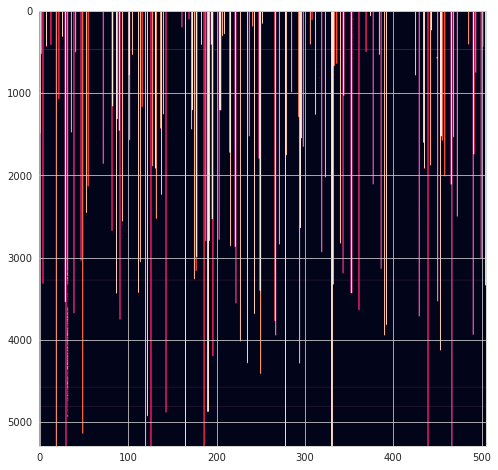

In [104]:
#### Investigate Missing Values
data = pd.read_pickle("gdrive/My Drive/Colab Notebooks/SVM MVO/DATA/STOCKS.pkl")
plt.figure(figsize = FigSize)
plt.imshow(data['Adj Close'].isna().astype(int),aspect='auto');

In [ ]:
P = data['Adj Close'].sort_index()
P = P[~P.isna().all(axis=1)] #dropping rows with all missing values
P = P.loc[:,~P.isna().any(axis=0)]
P.head()
P.tail()

,AAPL,ABC,ABMD,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP,AES,AFL,AIG,AIV,AJG,AKAM,ALB,ALK,ALL,AMAT,AMD,AME,AMGN,AMT,AMZN,ANSS,AON,AOS,APA,APD,APH,ARE,ATO,ATVI,AVB,AVY,AXP,AZO,BA,...,TSCO,TSN,TT,TXN,TXT,UDR,UHS,UNH,UNM,UNP,URI,USB,VFC,VLO,VMC,VNO,VRSN,VRTX,VZ,WAB,WAT,WBA,WDC,WEC,WELL,WFC,WHR,WM,WMB,WMT,WRB,WY,XEL,XLNX,XOM,XRAY,XRX,YUM,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-10-26,114.314743,96.840866,288.320007,107.755257,475.200012,119.072983,49.897430,142.921768,249.130005,81.843948,90.452118,20.059576,35.855831,30.433784,3.302060,104.639969,106.059998,93.617043,38.580002,88.634789,59.010246,82.230003,104.448448,218.488724,232.382294,3207.040039,321.000000,200.405899,52.987339,8.523028,280.371338,57.727531,153.909027,95.003487,80.102150,138.669815,137.350677,96.001678,1152.000000,160.830002,...,134.285309,56.056656,124.444710,142.450455,33.963573,31.164209,114.326958,318.473907,18.306435,181.236267,182.119995,38.713230,71.957771,37.240547,139.874268,31.409128,198.580002,207.149994,55.960209,59.907600,220.309998,35.762562,40.490002,99.365616,53.760624,22.378538,189.251862,111.468498,17.967398,139.986420,62.922436,27.491661,69.746231,114.225449,31.090204,47.270721,18.109182,97.513008,295.100006,31.563892
2020-10-27,115.854828,96.132057,290.510010,107.340057,478.559998,118.247253,49.088394,143.176682,250.600006,81.970528,89.427666,19.825645,34.480888,30.336426,3.170018,104.058418,106.709999,94.310638,37.470001,86.897614,58.335960,78.879997,101.954010,217.099442,231.441483,3286.330078,322.170013,197.739365,52.103065,8.313935,277.532379,57.033516,153.251495,94.603897,80.569885,135.284821,136.265656,94.069366,1133.589966,155.240005,...,132.614746,56.261524,122.008095,143.592377,32.905025,30.325363,110.940674,315.960114,17.364471,176.202469,174.809998,37.211590,70.621048,36.034981,140.875549,30.527967,199.059998,212.190002,55.543964,58.257587,223.960007,34.599640,40.320000,99.618385,52.148769,21.510998,190.968262,108.745682,18.173273,140.685547,60.594894,26.631638,70.368874,123.997673,30.596119,47.201225,17.726326,96.323586,289.279999,30.221985
2020-10-28,110.489342,94.212357,283.000000,105.204727,456.970001,114.492126,48.269600,152.049850,237.619995,79.224876,87.291748,19.006886,33.300976,29.431007,2.998263,102.816452,97.400002,89.950836,35.709999,85.882645,56.838638,76.400002,97.581291,210.220947,225.531967,3162.780029,308.029999,193.001083,50.560513,7.756354,267.233795,55.278637,149.335815,90.335190,78.629288,128.350357,133.306580,90.769554,1128.849976,148.139999,...,131.033188,55.373749,126.111862,139.571167,32.046192,28.872007,105.940926,303.627686,15.765987,170.118729,170.729996,36.136223,66.728027,34.085365,136.295334,28.775118,189.830002,208.339996,54.508202,55.832253,224.770004,33.244480,38.810001,96.983810,50.440399,20.880062,183.771133,105.138199,17.649227,137.898834,59.894665,26.506020,68.354996,119.420685,29.430820,44.520458,16.491608,93.443413,285.200012,29.755238
2020-10-29,114.583015,93.119614,254.610001,103.800949,461.109985,116.468002,48.659496,155.099091,242.839996,79.195663,87.504379,19.176758,33.369236,30.462992,3.061802,101.525200,95.820000,92.913521,36.779999,86.458443,59.000336,78.019997,98.296829,211.619980,227.021576,3211.010010,310.850006,185.170029,52.713287,8.154626,270.944000,56.101543,148.688110,89.740677,77.395256,131.658005,137.903015,90.244354,1129.760010,148.289993,...,131.487885,55.842030,130.264954,143.709763,34.023495,29.184137,105.024620,299.369019,16.496927,172.738647,173.220001,36.882198,67.186600,35.347435,142.263489,28.614048,191.589996,207.009995,54.943802,58.396740,225.580002,32.216103,38.110001,97.625435,52.727882,20.840628,181.762161,105.718147,17.873819,137.780685,60.200401,27.453009,68.821983,122.551788,30.735954,44.480747,16.893608,93.325455,291.970001,30.688736
2020-10-30,108.164314,94.576607,251.880005,103.909683,447.100006,116.517136,45.072422,154.873581,235.539993,78.981468,86.914833,19.147301,33.105949,30.657703,3.167039,102.2

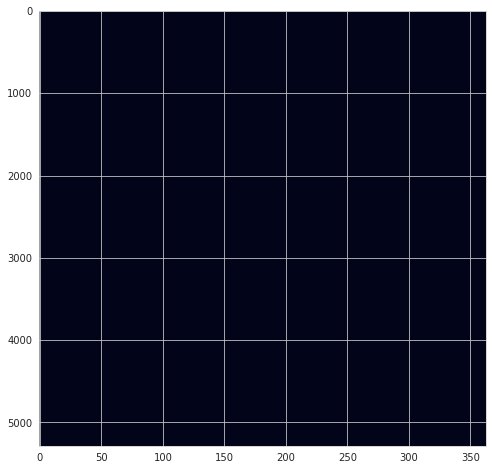

In [ ]:
#### No more missing values
plt.figure(figsize = FigSize)
plt.imshow(P.isna().astype(int),aspect='auto');

In [ ]:
### Export Tickers for WRDS, since WRDS python API does not have access to fundq dataset from S&P Compustat
pd.Series(P.columns).to_csv('gdrive/My Drive/Colab Notebooks/SVM MVO/DATA/wrds_tickers.csv')

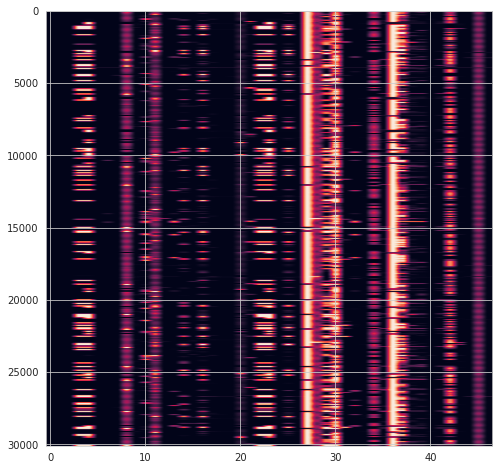

In [ ]:
wrds = pd.read_csv('gdrive/My Drive/Colab Notebooks/SVM MVO/DATA/WRDS_OUT.csv')
plt.figure(figsize=FigSize)
plt.imshow(wrds.isna().astype(int),aspect='auto');
wrds.head()
wrds['date'] = pd.to_datetime(wrds.datadate, format = '%Y%m%d')

In [ ]:
#fix the column names and define the variables of interest as per 
wrds.rename(columns=str.lower, inplace = True)
wrds.columns = wrds.columns.str.replace(' ', '')
wrds

,datadate,tic,srcq,actq,ancq,atq,ceqq,cheq,chq,cogsq,cshiq,cshopq,cshoq,cstkq,dlcq,dlttq,dpq,epspi12,epspiq,epspxq,intanq,invtq,lctq,lltq,niq,oibdpq,opepsq,pllq,pncepsq,ppegtq,recdq,rectq,req,saleq,teqq,capxy,depcy,dlcchy,dltisy,dltry,niy,oancfy,txpdy,txty,dvpspq,mkvaltq,prccq,date
0,19991231,AAPL,5,4909.0,2677.0,7586.0,4264.0,3660.0,NaN,1716.0,161.224,NaN,161.224,1345.0,0.0,300.0,20.0,4.230,1.14,1.14,NaN,15.0,1965.0,1207.0,183.0,218.0,1.53,NaN,NaN,725.0,NaN,892.0,2919.0,2343.0,NaN,38.0,NaN,0.0,0.0,0.0,183.0,373.0,8.0,91.0,0.00,NaN,102.8125,1999-12-31
1,20000331,AAPL,5,4912.0,2095.0,7007.0,4065.0,3609.0,NaN,1375.0,162.680,NaN,162.680,1419.0,0.0,300.0,21.0,4.670,1.44,1.44,NaN,10.0,1853.0,939.0,233.0,191.0,1.44,NaN,NaN,723.0,NaN,940.0,2646.0,1945.0,NaN,65.0,NaN,0.0,0.0,0.0,416.0,434.0,37.0,177.0,0.00,NaN,135.8125,2000-03-31
2,20000630,AAPL,5,5157.0,1775.0,6932.0,4026.0,3826.0,NaN,1257.0,324.826,NaN,324.826,1376.0,0.0,300.0,25.0,2.245,0.62,0.62,NaN,5.0,1873.0,883.0,200.0,193.0,0.62,NaN,NaN,721.0,NaN,967.0,2650.0,1825.0,NaN,76.0,NaN,0.0,0.0,0.0,616.0,668.0,36.0,247.0,0.00,NaN,52.3750,2000-06-30
3,20000930,AAPL,5,5427.0,1376.0,6803.0,4031.0,4027.0,NaN,1385.0,335.677,NaN,335.677,1502.0,0.0,300.0,18.0,2.420,0.52,0.52,NaN,33.0,1933.0,763.0,170.0,102.0,0.52,NaN,NaN,700.0,NaN,953.0,2529.0,1870.0,NaN,107.0,NaN,0.0,0.0,0.0,786.0,826.0,47.0,306.0,0.00,NaN,25.7500,2000-09-30
4,20001231,AAPL,5,4926.0,1060.0,5986.0,3709.0,4065.0,NaN,1004.0,345.307,NaN,345.307,1578.0,0.0,311.0,24.0,1.280,-0.58,-0.61,NaN,21.0,1637.0,637.0,-195.0,-396.0,-0.61,NaN,0.0,NaN,NaN,441.0,2131.0,1007.0,NaN,22.0,NaN,0.0,0.0,0.0,-195.0,-13.0,9.0,-88.0,0.00,NaN,14.8750,2000-12-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30091,20190930,ZION,5,NaN,NaN,70361.0,6943.0,2449.0,NaN,120.0,170.373,6.638,170.373,3002.0,4579.0,1492.0,50.0,4.520,1.23,1.23,1014.0,145.0,NaN,NaN,222.0,362.0,1.23,10.0,NaN,NaN,NaN,48325.0,3941.0,823.0,7509.0,94.0,NaN,-1074.0,497.0,0.0,633.0,346.0,179.0,185.0,0.34,7585.0060,44.5200,2019-09-30
30092,20191231,ZION,5,NaN,NaN,69172.0,6787.0,1932.0,NaN,91.0,165.057,5.529,165.057,2735.0,2053.0,1969.0,45.0,4.410,1.03,1.03,1014.0,137.0,NaN,NaN,183.0,334.0,1.03,4.0,NaN,NaN,NaN,48214.0,4052.0,799.0,7353.0,117.0,NaN,-3600.0,992.0,0.0,816.0,697.0,233.0,237.0,0.34,8569.7594,51.9200,2019-12-31
30093,20200331,ZION,5,NaN,NaN,71467.0,6906.0,2505.0,NaN,332.0,163.852,1.669,163.852,2668.0,3765.0,2035.0,45.0,3.350,0.04,0.04,1014.0,146.0,NaN,NaN,14.0,85.0,0.04,258.0,NaN,NaN,NaN,49197.0,4238.0,756.0,7472.0,28.0,NaN,1712.0,0.0,0.0,14.0,153.0,1.0,2.0,0.34,4384.6795,26.7600,2020-03-31
30094,20200630,ZION,5,NaN,NaN,76447.0,7009.0,2415.0,NaN,200.0,163.978,0.011,163.978,2675.0,860.0,1590.0,18.0,2.640,0.34,0.34,1014.0,110.0,NaN,NaN,66.0,181.0,0.48,168.0,NaN,NaN,NaN,54269.0,4334.0,712.0,7575.0,82.0,NaN,-1194.0,0.0,429.0,80.0,398.0,17.0,18.0,0.34,5575.2520,34.0000,2020-06-30


In [ ]:
#for each company, how many quarterly reports are there
ReportCountsbyTicker = wrds.groupby(by = 'tic').count().sort_values(by = 'datadate')
#we do not have data for these companies (3 companies - no data)
P.loc[:,P.columns[~P.columns.isin(ReportCountsbyTicker.index)]]

,BF-B,BRK-B,COG
Date,,,
1999-11-01,4.731973,41.740002,1.202743
1999-11-02,4.688560,42.820000,1.225231
1999-11-03,4.671194,43.060001,1.270313
1999-11-04,4.705925,43.259998,1.283827
1999-11-05,4.753679,42.619999,1.234312
...,...,...,...
2020-10-26,72.064468,208.490005,18.872143
2020-10-27,71.598969,206.880005,18.628191
2020-10-28,68.964386,200.699997,17.730450


,datadate,tic,srcq,actq,ancq,atq,ceqq,cheq,chq,cogsq,cshiq,cshopq,cshoq,cstkq,dlcq,dlttq,dpq,epspi12,epspiq,epspxq,intanq,invtq,lctq,lltq,niq,oibdpq,opepsq,pllq,pncepsq,ppegtq,recdq,rectq,req,saleq,teqq,capxy,depcy,dlcchy,dltisy,dltry,niy,oancfy,txpdy,txty,dvpspq,mkvaltq,prccq,date
0,19991231,AAPL,5,4909.0,2677.0,7586.0,4264.0,3660.0,NaN,1716.0,161.224,NaN,161.224,1345.0,0.0,300.0,20.0,4.230,1.14,1.14,NaN,15.0,1965.0,1207.0,183.0,218.0,1.53,NaN,NaN,725.0,NaN,892.0,2919.0,2343.0,NaN,38.0,NaN,0.0,0.0,0.0,183.0,373.0,8.0,91.0,0.00,NaN,102.8125,1999-12-31
1,20000331,AAPL,5,4912.0,2095.0,7007.0,4065.0,3609.0,NaN,1375.0,162.680,NaN,162.680,1419.0,0.0,300.0,21.0,4.670,1.44,1.44,NaN,10.0,1853.0,939.0,233.0,191.0,1.44,NaN,NaN,723.0,NaN,940.0,2646.0,1945.0,NaN,65.0,NaN,0.0,0.0,0.0,416.0,434.0,37.0,177.0,0.00,NaN,135.8125,2000-03-31
2,20000630,AAPL,5,5157.0,1775.0,6932.0,4026.0,3826.0,NaN,1257.0,324.826,NaN,324.826,1376.0,0.0,300.0,25.0,2.245,0.62,0.62,NaN,5.0,1873.0,883.0,200.0,193.0,0.62,NaN,NaN,721.0,NaN,967.0,2650.0,1825.0,NaN,76.0,NaN,0.0,0.0,0.0,616.0,668.0,36.0,247.0,0.00,NaN,52.3750,2000-06-30
3,20000930,AAPL,5,5427.0,1376.0,6803.0,4031.0,4027.0,NaN,1385.0,335.677,NaN,335.677,1502.0,0.0,300.0,18.0,2.420,0.52,0.52,NaN,33.0,1933.0,763.0,170.0,102.0,0.52,NaN,NaN,700.0,NaN,953.0,2529.0,1870.0,NaN,107.0,NaN,0.0,0.0,0.0,786.0,826.0,47.0,306.0,0.00,NaN,25.7500,2000-09-30
4,20001231,AAPL,5,4926.0,1060.0,5986.0,3709.0,4065.0,NaN,1004.0,345.307,NaN,345.307,1578.0,0.0,311.0,24.0,1.280,-0.58,-0.61,NaN,21.0,1637.0,637.0,-195.0,-396.0,-0.61,NaN,0.0,NaN,NaN,441.0,2131.0,1007.0,NaN,22.0,NaN,0.0,0.0,0.0,-195.0,-13.0,9.0,-88.0,0.00,NaN,14.8750,2000-12-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30091,20190930,ZION,5,NaN,NaN,70361.0,6943.0,2449.0,NaN,120.0,170.373,6.638,170.373,3002.0,4579.0,1492.0,50.0,4.520,1.23,1.23,1014.0,145.0,NaN,NaN,222.0,362.0,1.23,10.0,NaN,NaN,NaN,48325.0,3941.0,823.0,7509.0,94.0,NaN,-1074.0,497.0,0.0,633.0,346.0,179.0,185.0,0.34,7585.0060,44.5200,2019-09-30
30092,20191231,ZION,5,NaN,NaN,69172.0,6787.0,1932.0,NaN,91.0,165.057,5.529,165.057,2735.0,2053.0,1969.0,45.0,4.410,1.03,1.03,1014.0,137.0,NaN,NaN,183.0,334.0,1.03,4.0,NaN,NaN,NaN,48214.0,4052.0,799.0,7353.0,117.0,NaN,-3600.0,992.0,0.0,816.0,697.0,233.0,237.0,0.34,8569.7594,51.9200,2019-12-31
30093,20200331,ZION,5,NaN,NaN,71467.0,6906.0,2505.0,NaN,332.0,163.852,1.669,163.852,2668.0,3765.0,2035.0,45.0,3.350,0.04,0.04,1014.0,146.0,NaN,NaN,14.0,85.0,0.04,258.0,NaN,NaN,NaN,49197.0,4238.0,756.0,7472.0,28.0,NaN,1712.0,0.0,0.0,14.0,153.0,1.0,2.0,0.34,4384.6795,26.7600,2020-03-31
30094,20200630,ZION,5,NaN,NaN,76447.0,7009.0,2415.0,NaN,200.0,163.978,0.011,163.978,2675.0,860.0,1590.0,18.0,2.640,0.34,0.34,1014.0,110.0,NaN,NaN,66.0,181.0,0.48,168.0,NaN,NaN,NaN,54269.0,4334.0,712.0,7575.0,82.0,NaN,-1194.0,0.0,429.0,80.0,398.0,17.0,18.0,0.34,5575.2520,34.0000,2020-06-30


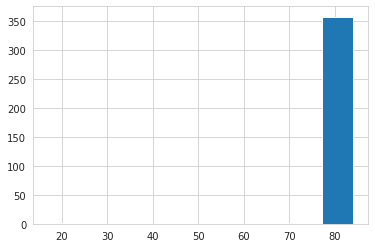

In [ ]:
#these are columns that are in the balance reports
ColumnsCovered =  P.columns[P.columns.isin(ReportCountsbyTicker.index)]
ColumnsCovered
#there are a lot of tickers with decent coverage
plt.hist(ReportCountsbyTicker.loc[ReportCountsbyTicker.index.isin(ColumnsCovered), 'datadate']);
wrds[wrds.tic.isin(ColumnsCovered)]

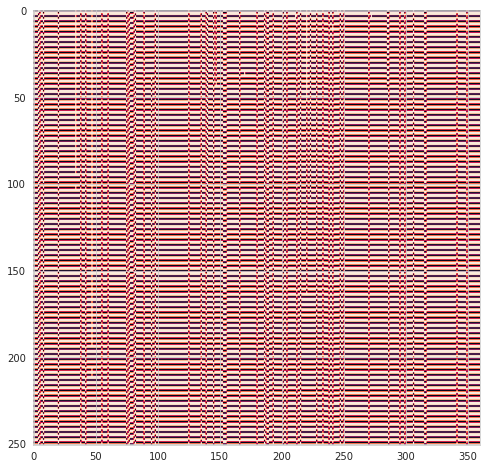

In [ ]:
#the reporting coverage is visualized below
#the y axis is the date and the x axis is the ticker
plt.figure(figsize = FigSize)
wrdsbydate = wrds.loc[wrds.tic.isin(ColumnsCovered),
                                        ['tic', 'date', 'datadate']].pivot(index='date', columns='tic', values='datadate')

plt.imshow(wrdsbydate.isna().astype(int),aspect='auto');

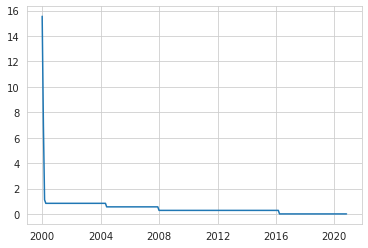

In [ ]:
#for each date what % of ticker have missing reports? 
dates = np.array([])
stats = np.array([])
wrdsbydate.isna().astype(int)
for date in wrdsbydate.index:
  dates = np.append(dates, date)
  wrdsbydate[:date]
  stats = np.append(stats, wrdsbydate[:date].isna().all(axis = 0).mean())
#find the % of columns that have a date before the cut off date
plt.plot(dates, 100*stats);


In [ ]:
#from the chart above, pick a threshold of about 2% (i.e keep 98% of tickers) and then set a cut off date for the stock data after that
cut_dt = np.min(dates[stats < 0.02])
columnscovered2 = ~(wrdsbydate[:cut_dt].isna().all(axis = 0))
print('% of columns maintained', sum(columnscovered2)/len(columnscovered2))
wrdsbydate.columns[columnscovered2]

% of columns maintained 0.9888888888888889


Index(['AAPL', 'ABC', 'ABMD', 'ABT', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK',
       'AEE',
       ...
       'WRB', 'WY', 'XEL', 'XLNX', 'XOM', 'XRAY', 'XRX', 'YUM', 'ZBRA',
       'ZION'],
      dtype='object', name='tic', length=356)

columns dropped
 ['pncepsq', 'dlcchy', 'depcy', 'cshopq', 'oibdpq', 'dpq', 'recdq', 'cshiq', 'intanq', 'mkvaltq', 'txpdy', 'dlcq', 'pllq', 'lctq', 'lltq', 'ancq', 'chq', 'ppegtq', 'teqq', 'actq']


,datadate,tic,srcq,atq,ceqq,cheq,cogsq,cshoq,cstkq,dlttq,epspi12,epspiq,epspxq,invtq,niq,opepsq,rectq,req,saleq,capxy,dltisy,dltry,niy,oancfy,txty,dvpspq,prccq,date
0,19991231,AAPL,5,7586.0,4264.0,3660.0,1716.0,161.224,1345.0,300.0,4.230,1.14,1.14,15.0,183.0,1.53,892.0,2919.0,2343.0,38.0,0.0,0.0,183.0,373.0,91.0,0.0,102.8125,1999-12-31
1,20000331,AAPL,5,7007.0,4065.0,3609.0,1375.0,162.680,1419.0,300.0,4.670,1.44,1.44,10.0,233.0,1.44,940.0,2646.0,1945.0,65.0,0.0,0.0,416.0,434.0,177.0,0.0,135.8125,2000-03-31
2,20000630,AAPL,5,6932.0,4026.0,3826.0,1257.0,324.826,1376.0,300.0,2.245,0.62,0.62,5.0,200.0,0.62,967.0,2650.0,1825.0,76.0,0.0,0.0,616.0,668.0,247.0,0.0,52.3750,2000-06-30
3,20000930,AAPL,5,6803.0,4031.0,4027.0,1385.0,335.677,1502.0,300.0,2.420,0.52,0.52,33.0,170.0,0.52,953.0,2529.0,1870.0,107.0,0.0,0.0,786.0,826.0,306.0,0.0,25.7500,2000-09-30
4,20001231,AAPL,5,5986.0,3709.0,4065.0,1004.0,345.307,1578.0,311.0,1.280,-0.58,-0.61,21.0,-195.0,-0.61,441.0,2131.0,1007.0,22.0,0.0,0.0,-195.0,-13.0,-88.0,0.0,14.8750,2000-12-31


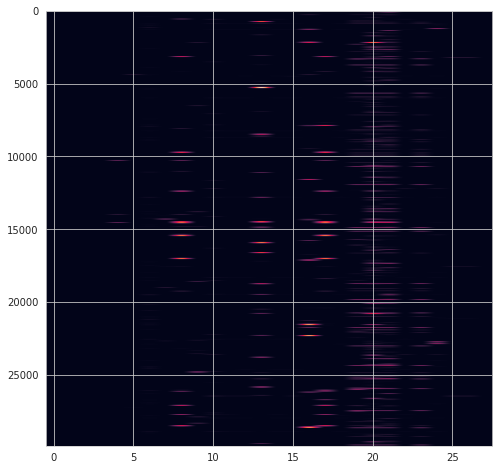

In [ ]:
### Remove columns that have a are missing for a large % of tickers
wrds2 = wrds[wrds.tic.isin(wrdsbydate.columns[columnscovered2])]
allna = (wrds2.groupby('tic').count() == 0).sum(axis = 0)
columns_to_remove = list(set(wrds2.columns[wrds2.isna().mean() > 0.05]) | set(allna[allna > 5].index))
wrds3 = wrds2.drop(columns = columns_to_remove).sort_values(by = ['tic', 'datadate'])

plt.figure(figsize = FigSize)
plt.imshow(wrds3.isna().astype(int),aspect='auto');
print("columns dropped\n", columns_to_remove)
wrds3.head()

Number of tickers with a full missing info for at least one column 0
tickers dropped
 Index([], dtype='object', name='tic')


,datadate,tic,srcq,atq,ceqq,cheq,cogsq,cshoq,cstkq,dlttq,epspi12,epspiq,epspxq,invtq,niq,opepsq,rectq,req,saleq,capxy,dltisy,dltry,niy,oancfy,txty,dvpspq,prccq,date
0,19991231,AAPL,5,7586.0,4264.0,3660.0,1716.0,161.224,1345.0,300.0,4.230,1.14,1.14,15.0,183.0,1.53,892.0,2919.0,2343.0,38.0,0.0,0.0,183.0,373.0,91.0,0.0,102.8125,1999-12-31
1,20000331,AAPL,5,7007.0,4065.0,3609.0,1375.0,162.680,1419.0,300.0,4.670,1.44,1.44,10.0,233.0,1.44,940.0,2646.0,1945.0,65.0,0.0,0.0,416.0,434.0,177.0,0.0,135.8125,2000-03-31
2,20000630,AAPL,5,6932.0,4026.0,3826.0,1257.0,324.826,1376.0,300.0,2.245,0.62,0.62,5.0,200.0,0.62,967.0,2650.0,1825.0,76.0,0.0,0.0,616.0,668.0,247.0,0.0,52.3750,2000-06-30
3,20000930,AAPL,5,6803.0,4031.0,4027.0,1385.0,335.677,1502.0,300.0,2.420,0.52,0.52,33.0,170.0,0.52,953.0,2529.0,1870.0,107.0,0.0,0.0,786.0,826.0,306.0,0.0,25.7500,2000-09-30
4,20001231,AAPL,5,5986.0,3709.0,4065.0,1004.0,345.307,1578.0,311.0,1.280,-0.58,-0.61,21.0,-195.0,-0.61,441.0,2131.0,1007.0,22.0,0.0,0.0,-195.0,-13.0,-88.0,0.0,14.8750,2000-12-31


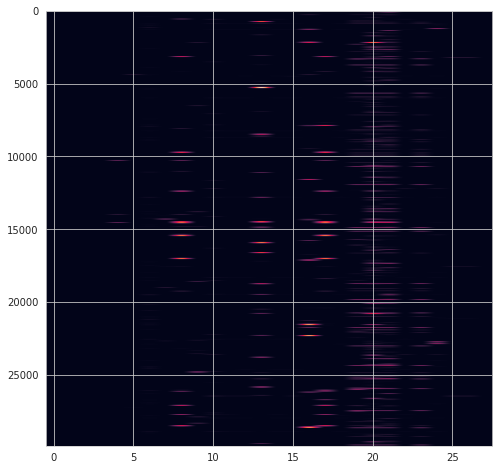

In [ ]:
AllNaTickers = (wrds3.groupby('tic').count() == 0).sum(axis = 1)
print("Number of tickers with a full missing info for at least one column", 
      sum(AllNaTickers[AllNaTickers > 0])) ## drop these tickers as well since they have columns all na for columns that have good coverage
tickers_to_drop = AllNaTickers[AllNaTickers>0].index
wrds4= wrds3[~wrds3.tic.isin(tickers_to_drop)]
plt.figure(figsize = FigSize)
plt.imshow(wrds4.isna().astype(int),aspect='auto');
print("tickers dropped\n", tickers_to_drop)
wrds4.head()

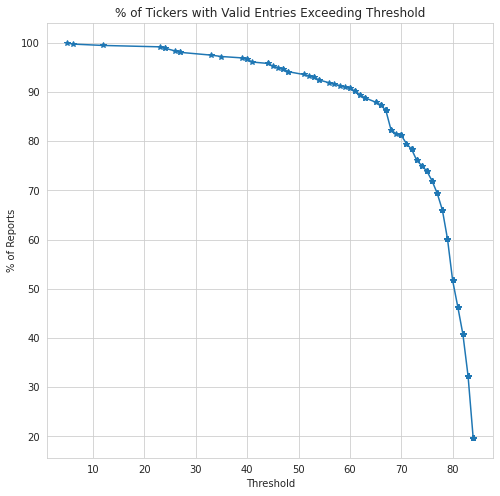

In [ ]:
numvalid_by_tic = wrds4.groupby('tic').count().min(axis=1).sort_values()
#for each date what % of ticker have missing reports? 
cut_offs = np.array([])
stats = np.array([])
for cut in numvalid_by_tic.values:
  cut_offs = np.append(cut_offs, cut)
  stats = np.append(stats, (numvalid_by_tic  >= cut).mean())
plt.figure(figsize = (FigSize))
plt.plot(cut_offs, 100*stats, '-*');
plt.title("% of Tickers with Valid Entries Exceeding Threshold")
plt.xlabel("Threshold")
plt.ylabel("% of Reports");

In [ ]:
### KNN for the missing values
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2, weights="uniform")
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
Y = wrds4.select_dtypes(include=numerics)
wrds_compare = wrds4.copy(deep=True)
imputer.fit_transform(Y.values)
Y_cleaned = imputer.transform(Y.values)

In [ ]:
Y

,datadate,srcq,atq,ceqq,cheq,cogsq,cshoq,cstkq,dlttq,epspi12,epspiq,epspxq,invtq,niq,opepsq,rectq,req,saleq,capxy,dltisy,dltry,niy,oancfy,txty,dvpspq,prccq
0,19991231.0,5.0,7586.0,4264.0,3660.0,1716.0,161.224,1345.0,300.0,4.230,1.14,1.14,15.0,183.0,1.53,892.0,2919.0,2343.0,38.0,0.0,0.0,183.0,373.0,91.0,0.00,102.8125
1,20000331.0,5.0,7007.0,4065.0,3609.0,1375.0,162.680,1419.0,300.0,4.670,1.44,1.44,10.0,233.0,1.44,940.0,2646.0,1945.0,65.0,0.0,0.0,416.0,434.0,177.0,0.00,135.8125
2,20000630.0,5.0,6932.0,4026.0,3826.0,1257.0,324.826,1376.0,300.0,2.245,0.62,0.62,5.0,200.0,0.62,967.0,2650.0,1825.0,76.0,0.0,0.0,616.0,668.0,247.0,0.00,52.3750
3,20000930.0,5.0,6803.0,4031.0,4027.0,1385.0,335.677,1502.0,300.0,2.420,0.52,0.52,33.0,170.0,0.52,953.0,2529.0,1870.0,107.0,0.0,0.0,786.0,826.0,306.0,0.00,25.7500
4,20001231.0,5.0,5986.0,3709.0,4065.0,1004.0,345.307,1578.0,311.0,1.280,-0.58,-0.61,21.0,-195.0,-0.61,441.0,2131.0,1007.0,22.0,0.0,0.0,-195.0,-13.0,-88.0,0.00,14.8750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30091,20190930.0,5.0,70361.0,6943.0,2449.0,120.0,170.373,3002.0,1492.0,4.520,1.23,1.23,145.0,222.0,1.23,48325.0,3941.0,823.0,94.0,497.0,0.0,633.0,346.0,185.0,0.34,44.5200
30092,20191231.0,5.0,69172.0,6787.0,1932.0,91.0,165.057,2735.0,1969.0,4.410,1.03,1.03,137.0,183.0,1.03,48214.0,4052.0,799.0,117.0,992.0,0.0,816.0,697.0,237.0,0.34,51.9200
30093,20200331.0,5.0,71467.0,6906.0,2505.0,332.0,163.852,2668.0,2035.0,3.350,0.04,0.04,146.0,14.0,0.04,49197.0,4238.0,756.0,28.0,0.0,0.0,14.0,153.0,2.0,0.34,26.7600
30094,20200630.0,5.0,76447.0,7009.0,2415.0,200.0,163.978,2675.0,1590.0,2.640,0.34,0.34,110.0,66.0,0.48,54269.0,4334.0,712.0,82.0,0.0,429.0,80.0,398.0,18.0,0.34,34.0000


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


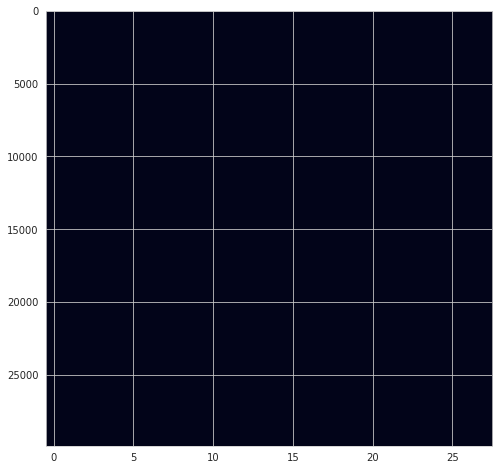

In [ ]:
Y.loc[:,:] = Y_cleaned
wrds4.update(Y)
plt.figure(figsize = FigSize)
plt.imshow(wrds4.isna().astype(int),aspect='auto');

In [ ]:
y4 = wrds4.select_dtypes(include=numerics)
ycompare = wrds_compare.select_dtypes(include=numerics)
diff = y4 - ycompare
diff[(~(y4 == ycompare)).any(axis = 1)]

,datadate,srcq,atq,ceqq,cheq,cogsq,cshoq,cstkq,dlttq,epspi12,epspiq,epspxq,invtq,niq,opepsq,rectq,req,saleq,capxy,dltisy,dltry,niy,oancfy,txty,dvpspq,prccq


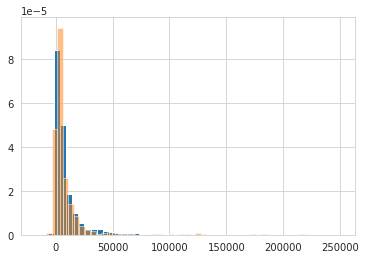

In [ ]:
UpdatedRows = (~(y4 == y5)).any(axis = 1)
UpdatedColumns = y4.columns[(~(y4 == y5)).any(axis = 0)]
#y4[UpdatedRows][UpdatedColumns].hist(figsize = (16,20));
#y4[~UpdatedRows][UpdatedColumns].hist(figsize = (16,20));
y4[~UpdatedRows]['ceqq'].hist(density = True, bins = 50, alpha=1);
y4[UpdatedRows]['ceqq'].hist(density = True, bins = 50, alpha = 0.5);

### Boyd's Paper drops the series that do not contain continuous observations

paper ctrl-f 'S&P' for details https://stanford.edu/~boyd/papers/pdf/cvx_portfolio.pdf 

Furthermore, to estimate the period return covariance matrix the log returns will be used to get daily  means and covariance matrices, then scaled to the desired time horizon and then transformed back to linear return estimates

In [ ]:
cut_dt

Timestamp('2000-02-29 00:00:00')

In [ ]:
logret = np.log1p(P.loc[:,P.columns[P.columns.isin(wrds4.tic.unique())]].pct_change()).dropna()

Calculate the exponentially weighted averages

In [ ]:
from pandas.tseries.offsets import MonthEnd, Day, MonthBegin

dates = pd.DataFrame(logret.index[logret.index >= cut_dt + MonthBegin(1)])
dates['Month'] = dates.Date.dt.month
#dates['Month'] = dates.Date.dt.month
dates['Year'] = dates.Date.dt.year

decision_dates = dates.groupby(by = ['Year','Month']).agg({'Date':'min', 'Year':'count'}).rename(columns={'Date':'Date', 'Year': 'ActualDays'})
decision_dates['MonthStart'] = decision_dates.Date +Day(1) + MonthBegin(-1)
decision_dates['MonthEnd'] = decision_dates.Date  + MonthBegin(1)

print(decision_dates)

                 Date  ActualDays MonthStart   MonthEnd
Year Month                                             
2000 3     2000-03-01          23 2000-03-01 2000-04-01
     4     2000-04-03          19 2000-04-01 2000-05-01
     5     2000-05-01          22 2000-05-01 2000-06-01
     6     2000-06-01          22 2000-06-01 2000-07-01
     7     2000-07-03          20 2000-07-01 2000-08-01
...               ...         ...        ...        ...
2020 6     2020-06-01          22 2020-06-01 2020-07-01
     7     2020-07-01          22 2020-07-01 2020-08-01
     8     2020-08-03          21 2020-08-01 2020-09-01
     9     2020-09-01          21 2020-09-01 2020-10-01
     10    2020-10-01          22 2020-10-01 2020-11-01

[248 rows x 4 columns]


In [ ]:
#as of the first business day, append on the expected number of trading days in the month
from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday, nearest_workday, \
    USMartinLutherKingJr, USPresidentsDay, GoodFriday, USMemorialDay, \
    USLaborDay, USThanksgivingDay

class USTradingCalendar(AbstractHolidayCalendar):
    rules = [
        Holiday('NewYearsDay', month=1, day=1, observance=nearest_workday),
        USMartinLutherKingJr,
        USPresidentsDay,
        GoodFriday,
        USMemorialDay,
        Holiday('USIndependenceDay', month=7, day=4, observance=nearest_workday),
        USLaborDay,
        USThanksgivingDay,
        Holiday('Christmas', month=12, day=25, observance=nearest_workday)
    ]

calendar = USTradingCalendar()

holidays = calendar.holidays(np.min(decision_dates.Date), np.max(decision_dates.MonthEnd))
holiday_date_list = holidays.date.tolist()
decision_dates["ExpectedDays"] = np.busday_count(decision_dates.MonthStart.values.astype('datetime64[D]'), 
                                                 decision_dates.MonthEnd.values.astype('datetime64[D]'), 
                                                 holidays = holiday_date_list)
decision_dates
decision_dates[decision_dates.ActualDays != decision_dates.ExpectedDays]

Date  ActualDays MonthStart   MonthEnd  ExpectedDays
Year Month                                                           
2001 9     2001-09-04          15 2001-09-01 2001-10-01            19
2004 6     2004-06-01          21 2004-06-01 2004-07-01            22
     12    2004-12-01          22 2004-12-01 2005-01-01            21
2007 1     2007-01-03          20 2007-01-01 2007-02-01            21
2010 12    2010-12-01          22 2010-12-01 2011-01-01            21
2012 10    2012-10-01          21 2012-10-01 2012-11-01            23
2018 12    2018-12-03          19 2018-12-01 2019-01-01            20

Year  Month
2001  9       -4
2012  10      -2
2018  12      -1
2004  6       -1
2007  1       -1
              ..
      10       0
2006  9        0
2020  10       0
2004  12       1
2010  12       1
Length: 248, dtype: int64

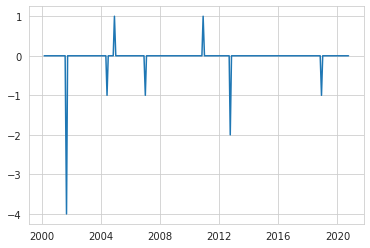

In [97]:
diff = (decision_dates.ActualDays - decision_dates.ExpectedDays);
plt.plot(decision_dates.Date, (decision_dates.ActualDays - decision_dates.ExpectedDays));
#2001 9 is missing 4 days due to 911 
#2012 10 is missing 2 days due to Katrina
#2004 6 is missing a day due to Ronald Reagans funeral
#2018 12 is missing a day due to George W. Bush funeral
#2010 and 2004 both have December 31st as a trading day. Even though
#the logic dictates that they should be a holiday. This info was likely known
# at trade time
# From this is it safe to conclude that the expected number of trading days in the month 
# is equal to the max of the two columns.
decision_dates['ExpectedDaysCorr'] = decision_dates['ExpectedDays']
diff.sort_values()

In [ ]:
#logret.AAPL.dropna().plot()
lambd = 0.94 #from risk metrics
EW_ret = logret.ewm(alpha=1-lambd).mean().dropna()

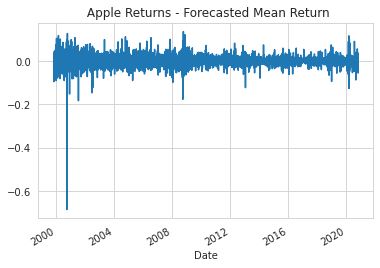

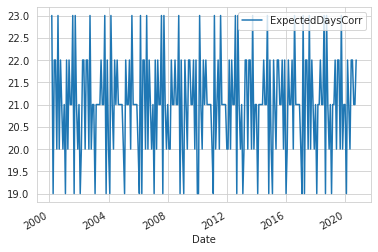

In [ ]:
(logret.AAPL - logret.AAPL.ewm(alpha=1-0.94).mean()).dropna().plot(title = ' Apple Returns - Forecasted Mean Return');
(logret.AAPL - logret.AAPL.ewm(alpha=1-0.94).mean()).sort_values() #September 29th 2000 was an interesting day for apple
decision_dates.plot(x = 'Date', y = 'ExpectedDaysCorr');

In [ ]:
### exponential weighted mean and covariance function
def eqma(df, alpha):
  weights = (1- alpha) ** np.arange(len(df))[::-1]
  normalized = (df - df.mean()).fillna(0).to_numpy()
  cov = ((weights *normalized.T))@normalized/weights.sum()
  mean = (df.multiply(weights, axis=0).values).sum(axis=0)/(weights.sum())
  
  return cov, mean

#plt.figure(figsize=(10,10))
#plt.matshow(eqma(logret, 1-0.94), fignum=1);
cov, mean = eqma(logret, 1-0.94)
np.max(mean - logret.mean())

0.008288405249011985

In [ ]:
# the covariance matrices are close
c1,m1 = eqma(logret['1999-11-02':'2000-03-01	'], 1-0.94)
c2,m2 = eqma(logret['1999-12-01':'2000-03-01'], 1-0.94)
(np.mean((c2 - c1)**2))**0.5
100*np.max(np.abs(m1-m2)) #such a small difference

0.09343034350680762

In [142]:
#for each month, estimate the exponentially weighted covariance matrix
forecasts_ew = {}
for date in decision_dates.Date:
  cov_1day, mean_1day = eqma(logret[logret.index < date], 1-lambd)
  idx = decision_dates.Date == date
  k = decision_dates[idx].ExpectedDays.values[0] #this is one to one
  cov = k*cov_1day
  mean = k*mean_1day
  cov_ii = np.expand_dims(np.diag(cov), axis = 1)
  #convert to linear returns
  logmean = np.expand_dims(np.e**(mean + np.diag(cov)/2), axis = 1)
  NbyN = (len(mean),len(mean))
  means_added =  mean_*np.ones( NbyN )  + mean_.transpose()*np.ones( NbyN )
  covdiags_added = (1/2)*(cov_ii*np.ones( NbyN )) + (1/2)*(cov_ii.transpose()*np.ones( NbyN ))
  logcov = (  np.e**(means_added + covdiags_added)  )*( np.e**(cov) - 1)
  forecasts_ew[date] = (logret, logmean) #estimate the covariance based on data that was available before the trade date

In [147]:
with open("gdrive/My Drive/Colab Notebooks/SVM MVO/DATA/Forecasts.pkl", 'wb') as fp:
    pkl.dump(forecasts_ew, fp);


Import wrds information

Join the wrds info to the decision dates. Full outer join on the report dates and the decision dates then filter to report date < decision date and take the most recent report date


In [100]:
wrds4.head()

,datadate,tic,srcq,atq,ceqq,cheq,cogsq,cshoq,cstkq,dlttq,epspi12,epspiq,epspxq,invtq,niq,opepsq,rectq,req,saleq,capxy,dltisy,dltry,niy,oancfy,txty,dvpspq,prccq,date
0,19991231.0,AAPL,5.0,7586.0,4264.0,3660.0,1716.0,161.224,1345.0,300.0,4.230,1.14,1.14,15.0,183.0,1.53,892.0,2919.0,2343.0,38.0,0.0,0.0,183.0,373.0,91.0,0.0,102.8125,1999-12-31
1,20000331.0,AAPL,5.0,7007.0,4065.0,3609.0,1375.0,162.680,1419.0,300.0,4.670,1.44,1.44,10.0,233.0,1.44,940.0,2646.0,1945.0,65.0,0.0,0.0,416.0,434.0,177.0,0.0,135.8125,2000-03-31
2,20000630.0,AAPL,5.0,6932.0,4026.0,3826.0,1257.0,324.826,1376.0,300.0,2.245,0.62,0.62,5.0,200.0,0.62,967.0,2650.0,1825.0,76.0,0.0,0.0,616.0,668.0,247.0,0.0,52.3750,2000-06-30
3,20000930.0,AAPL,5.0,6803.0,4031.0,4027.0,1385.0,335.677,1502.0,300.0,2.420,0.52,0.52,33.0,170.0,0.52,953.0,2529.0,1870.0,107.0,0.0,0.0,786.0,826.0,306.0,0.0,25.7500,2000-09-30
4,20001231.0,AAPL,5.0,5986.0,3709.0,4065.0,1004.0,345.307,1578.0,311.0,1.280,-0.58,-0.61,21.0,-195.0,-0.61,441.0,2131.0,1007.0,22.0,0.0,0.0,-195.0,-13.0,-88.0,0.0,14.8750,2000-12-31


In [101]:
q = """select a.*, b.*  from 
  decision_dates a 
  left join wrds4 b 
  on b.date < a.Date;"""
wrds_asof = sqldf(q, locals())

wrds_asof_uniq = wrds_asof.sort_values('date', ascending=False).groupby('Date').first()
wrds4.to_csv('gdrive/My Drive/Colab Notebooks/SVM MVO/DATA/WRDS_PROCESSED.csv')
wrds_asof_uniq.to_pickle("'gdrive/My Drive/Colab Notebooks/SVM MVO/DATA/WRDS_ASOF.pkl'")